In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


* 필요한 모듈 import

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' 
!apt -qq -y install fonts-nanum
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 33 not upgraded.


### PatientInfo의 confirmed_data와 released_date를 활용하여 지역별, 나이대별, 성별로 코로나 완치에 영향을 주는 요인이 있는지 확인해보자!

In [6]:
patientInfo = pd.read_csv('/content/gdrive/My Drive/dacon/COVID_19/PatientInfo.csv')
patientInfo.head()

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,male,50s,Korea,서울,강서구,overseas inflow,NaN,75,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,male,30s,Korea,서울,중랑구,overseas inflow,NaN,31,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,male,50s,Korea,서울,종로구,contact with patient,2002000001,17,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,male,20s,Korea,서울,마포구,overseas inflow,NaN,9,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,female,20s,Korea,서울,성북구,contact with patient,1000000002,2,NaN,2020-01-31,2020-02-24,NaN,released


### 지역별 완치 기간의 차이

In [58]:
patientInfo_location = patientInfo[['province','confirmed_date','released_date','state']]
patientInfo_location

,province,confirmed_date,released_date,state
0,서울,2020-01-23,2020-02-05,released
1,서울,2020-01-30,2020-03-02,released
2,서울,2020-01-30,2020-02-19,released
3,서울,2020-01-30,2020-02-15,released
4,서울,2020-01-31,2020-02-24,released
...,...,...,...,...
5160,제주도,2020-05-30,2020-06-13,released
5161,제주도,2020-06-16,2020-06-24,released
5162,제주도,2020-06-18,NaN,isolated
5163,제주도,2020-06-18,NaN,isolated


* province 별로 그룹화해보자! 예를 들어, 서울 강서구와 서울 중랑구는 같은 지역으로 취급한다.
* Missing data는 측정이 불가능 하므로 삭제한다.

In [59]:
patientInfo_location = patientInfo_location.dropna(how = "any") #결측값 삭제
patientInfo_location = patientInfo_location.reset_index()
patientInfo_location = patientInfo_location.drop(['index'],axis=1)
patientInfo_location.head(30)

,province,confirmed_date,released_date,state
0,서울,2020-01-23,2020-02-05,released
1,서울,2020-01-30,2020-03-02,released
2,서울,2020-01-30,2020-02-19,released
3,서울,2020-01-30,2020-02-15,released
4,서울,2020-01-31,2020-02-24,released
5,서울,2020-01-31,2020-02-19,released
6,서울,2020-01-31,2020-02-10,released
7,서울,2020-02-02,2020-02-24,released
8,서울,2020-02-05,2020-02-21,released
9,서울,2020-02-05,2020-02-29,released


* 확진날짜와 완치날짜가 string 형식으로 되어있으므로 datetime 형식으로 바꾸어준다. 이후 완치일과 확진일 간의 차이를 days로 변환하여 difference 행에 저장해준다.

In [60]:
import datetime

patientInfo_location['difference'] = ''
patientInfo_location['count'] = 1

for i in range(len(patientInfo_location)):
  original_confirmed_date = patientInfo_location['confirmed_date'][i]
  original_released_date = patientInfo_location['released_date'][i]
  if type(original_confirmed_date) is float:
    original_confirmed_date = str(original_date)
  if type(original_released_date) is float:
    original_released_date = str(original_released_date)
  convert_c_date = datetime.datetime.strptime(original_confirmed_date, "%Y-%m-%d").date()
  convert_r_date = datetime.datetime.strptime(original_released_date, "%Y-%m-%d").date()

  patientInfo_location['difference'][i] = int((convert_r_date-convert_c_date).days)

patientInfo_location 

,province,confirmed_date,released_date,state,difference,count
0,서울,2020-01-23,2020-02-05,released,13,1
1,서울,2020-01-30,2020-03-02,released,32,1
2,서울,2020-01-30,2020-02-19,released,20,1
3,서울,2020-01-30,2020-02-15,released,16,1
4,서울,2020-01-31,2020-02-24,released,24,1
...,...,...,...,...,...,...
1582,제주도,2020-04-03,2020-05-05,released,32,1
1583,제주도,2020-04-14,2020-04-26,released,12,1
1584,제주도,2020-05-09,2020-06-12,released,34,1
1585,제주도,2020-05-30,2020-06-13,released,14,1


* 같은 지역의 경우에는 차이를 합산하자. 위에서 count 열을 만든 이유는, 확진자 수의 합을 구하기 위해서이다. 

먼저, 몇 개의 시도가 있는지 확인한다.

In [61]:
patientInfo_location['province'].drop_duplicates()

0         서울
54        대구
58        광주
84        인천
181       대전
225       울산
275       세종
321      경기도
382      강원도
410     충청북도
460     충청남도
610     전라북도
631     전라남도
650     경상북도
1513    경상남도
1571     제주도
Name: province, dtype: object

In [62]:
patientInfo_location_diff = patientInfo_location[["province","difference"]]
patientInfo_location_diff

,province,difference
0,서울,13
1,서울,32
2,서울,20
3,서울,16
4,서울,24
...,...,...
1582,제주도,32
1583,제주도,12
1584,제주도,34
1585,제주도,14


In [63]:
patientInfo_location_cnt = patientInfo_location[["province","count"]]
patientInfo_location_cnt

,province,count
0,서울,1
1,서울,1
2,서울,1
3,서울,1
4,서울,1
...,...,...
1582,제주도,1
1583,제주도,1
1584,제주도,1
1585,제주도,1


In [64]:
patientInfo_location_diff = patientInfo_location_diff.groupby(["province"]).sum().reset_index()
patientInfo_location_cnt = patientInfo_location_cnt.groupby(["province"]).sum().reset_index()

In [67]:
patientInfo_location_diff['cnt'] = 1
patientInfo_location_diff['avg'] = 0.0

for i in range(len(patientInfo_location_diff)):
  patientInfo_location_diff['cnt'][i] = patientInfo_location_cnt['count'][i]
  avg = float(patientInfo_location_diff['difference'][i] / patientInfo_location_cnt['count'][i])
  patientInfo_location_diff['avg'][i] = avg

patientInfo_location_diff

,province,difference,cnt,avg
0,강원도,557,28,19.892857
1,경기도,1016,61,16.655738
2,경상남도,1422,58,24.517241
3,경상북도,22898,862,26.563805
4,광주,527,26,20.269231
5,대구,36,4,9.000000
6,대전,1007,44,22.886364
7,서울,822,54,15.222222
8,세종,1308,46,28.434783
9,울산,1105,50,22.100000


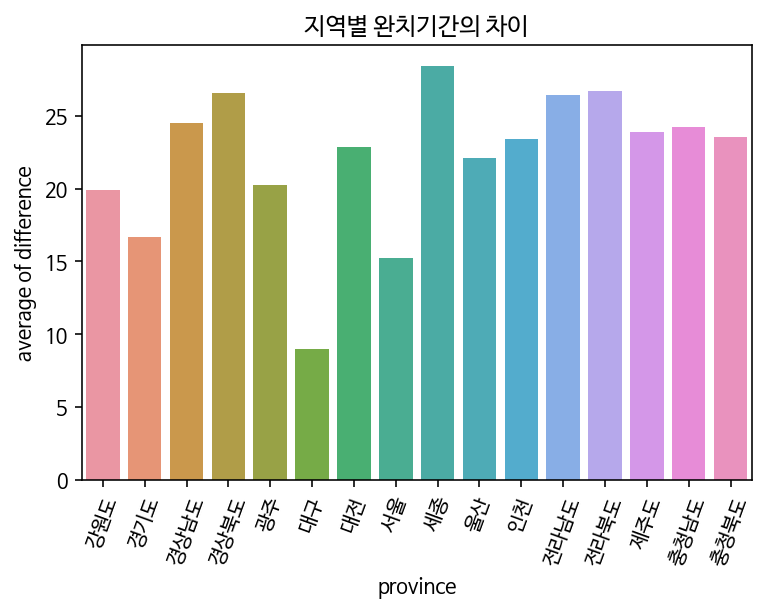

In [69]:
sns.barplot(x='province',y='avg',data=patientInfo_location_diff)
plt.title('지역별 완치기간의 차이')
plt.ylabel('average of difference')
plt.xticks(rotation=70)
plt.show()

* 그닥 유의미한 결과는 없는 것으로 보인다.

### 나이대별 완치 기간의 차이

In [85]:
patientInfo_age = patientInfo[["age","confirmed_date","released_date"]]
patientInfo_age = patientInfo_age.dropna(how="any").reset_index().drop(["index"],axis=1)
patientInfo_age.head(30)

,age,confirmed_date,released_date
0,50s,2020-01-23,2020-02-05
1,30s,2020-01-30,2020-03-02
2,50s,2020-01-30,2020-02-19
3,20s,2020-01-30,2020-02-15
4,20s,2020-01-31,2020-02-24
5,50s,2020-01-31,2020-02-19
6,20s,2020-01-31,2020-02-10
7,20s,2020-02-02,2020-02-24
8,30s,2020-02-05,2020-02-21
9,60s,2020-02-05,2020-02-29


* 지역별에서 했던 작업과 마찬가지로 완치일과 확진일 간의 차이를 구한다. 이 과정을 맨 처음 patientInfo 원본 데이터에서 해주지 않는 이유는, 이 작업을 위해서는 nan 값을 drop해야 하는데, 사용할 **지역, 나이, 성별, 확진일, 완치일** 이외의 값에서 nan이 발생할 경우 drop한다면 이후 작업할 데이터에서 손실이 발생할 수 있기 때문이다.

In [86]:
import datetime

patientInfo_age['difference'] = ''
patientInfo_age['count'] = 1

for i in range(len(patientInfo_age)):
  original_confirmed_date = patientInfo_age['confirmed_date'][i]
  original_released_date = patientInfo_age['released_date'][i]
  if type(original_confirmed_date) is float:
    original_confirmed_date = str(original_date)
  if type(original_released_date) is float:
    original_released_date = str(original_released_date)
  convert_c_date = datetime.datetime.strptime(original_confirmed_date, "%Y-%m-%d").date()
  convert_r_date = datetime.datetime.strptime(original_released_date, "%Y-%m-%d").date()

  patientInfo_age['difference'][i] = int((convert_r_date-convert_c_date).days)

patientInfo_age

,age,confirmed_date,released_date,difference,count
0,50s,2020-01-23,2020-02-05,13,1
1,30s,2020-01-30,2020-03-02,32,1
2,50s,2020-01-30,2020-02-19,20,1
3,20s,2020-01-30,2020-02-15,16,1
4,20s,2020-01-31,2020-02-24,24,1
...,...,...,...,...,...
1571,30s,2020-04-03,2020-05-19,46,1
1572,20s,2020-04-03,2020-05-05,32,1
1573,10s,2020-04-14,2020-04-26,12,1
1574,30s,2020-05-09,2020-06-12,34,1


* 위와 동일한 작업이므로 설명은 생략!

In [87]:
patientInfo_age_diff = patientInfo_age[["age","difference"]]
patientInfo_age_cnt = patientInfo_age[["age","count"]]

patientInfo_age_diff = patientInfo_age_diff.groupby(["age"]).sum().reset_index()
patientInfo_age_cnt = patientInfo_age_cnt.groupby(["age"]).sum().reset_index()


In [88]:
patientInfo_age_diff['cnt'] = 1
patientInfo_age_diff['avg'] = 0.0

for i in range(len(patientInfo_age_diff)):
  patientInfo_age_diff['cnt'][i] = patientInfo_age_cnt['count'][i]
  avg = float(patientInfo_age_diff['difference'][i] / patientInfo_age_cnt['count'][i])
  patientInfo_age_diff['avg'][i] = avg

patientInfo_age_diff = patientInfo_age_diff.sort_values(by='age', ascending=True)
patientInfo_age_diff

,age,difference,cnt,avg
0,0s,466,19,24.526316
1,100s,66,1,66.000000
2,10s,1353,65,20.815385
3,20s,9604,409,23.481663
4,30s,4894,211,23.194313
5,40s,5700,241,23.651452
6,50s,7164,300,23.880000
7,60s,4642,173,26.832370
8,70s,2723,83,32.807229
9,80s,2084,60,34.733333


* age가 문자열로 되어있으므로 나이대별 정렬이 불가능하다. s를 제거하여 int 변수로 만든 뒤 오름차순으로 정렬한다.

In [89]:
for i in range(len(patientInfo_age_diff)):
  age = patientInfo_age_diff["age"][i]
  age = age[:-1] #s 제거
  age = int(age)
  patientInfo_age_diff["age"][i] = age

patientInfo_age_diff = patientInfo_age_diff.sort_values(by='age', ascending=True).reset_index().drop(["index"],axis=1)
patientInfo_age_diff

,age,difference,cnt,avg
0,0,466,19,24.526316
1,10,1353,65,20.815385
2,20,9604,409,23.481663
3,30,4894,211,23.194313
4,40,5700,241,23.651452
5,50,7164,300,23.880000
6,60,4642,173,26.832370
7,70,2723,83,32.807229
8,80,2084,60,34.733333
9,90,403,14,28.785714


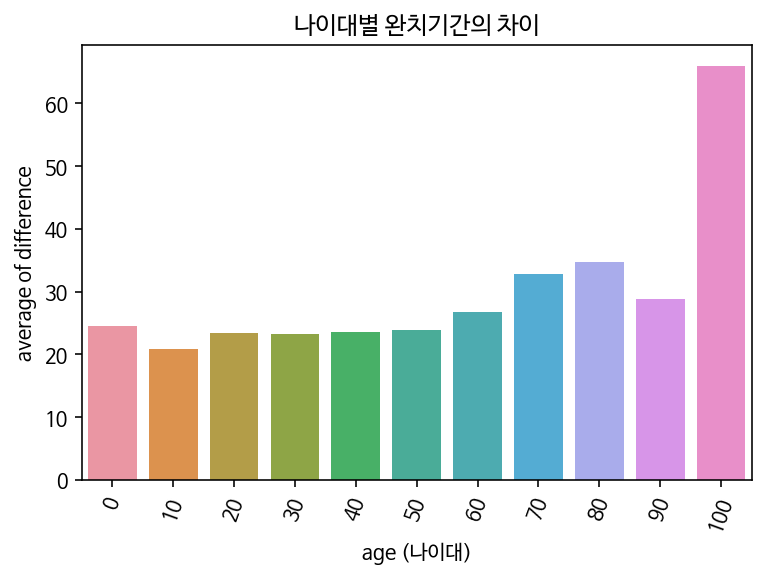

In [91]:
sns.barplot(x='age',y='avg',data=patientInfo_age_diff)
plt.title('나이대별 완치기간의 차이')
plt.xlabel('age (나이대)')
plt.ylabel('average of difference')
plt.xticks(rotation=70)
plt.show()

* 위 그래프를 통해 나이대가 높을 수록 완치 기간이 오래 걸린다는 경향을 확인할 수 있다.

### 성별 완치기간의 차이

In [94]:
patientInfo_sex = patientInfo[["sex","confirmed_date","released_date"]]
patientInfo_sex = patientInfo_sex.dropna(how="any").reset_index().drop(["index"],axis=1)
patientInfo_sex.head(30)

,sex,confirmed_date,released_date
0,male,2020-01-23,2020-02-05
1,male,2020-01-30,2020-03-02
2,male,2020-01-30,2020-02-19
3,male,2020-01-30,2020-02-15
4,female,2020-01-31,2020-02-24
5,female,2020-01-31,2020-02-19
6,male,2020-01-31,2020-02-10
7,male,2020-02-02,2020-02-24
8,male,2020-02-05,2020-02-21
9,female,2020-02-05,2020-02-29


In [95]:
import datetime

patientInfo_sex['difference'] = ''
patientInfo_sex['count'] = 1

for i in range(len(patientInfo_sex)):
  original_confirmed_date = patientInfo_sex['confirmed_date'][i]
  original_released_date = patientInfo_sex['released_date'][i]
  if type(original_confirmed_date) is float:
    original_confirmed_date = str(original_date)
  if type(original_released_date) is float:
    original_released_date = str(original_released_date)
  convert_c_date = datetime.datetime.strptime(original_confirmed_date, "%Y-%m-%d").date()
  convert_r_date = datetime.datetime.strptime(original_released_date, "%Y-%m-%d").date()

  patientInfo_sex['difference'][i] = int((convert_r_date-convert_c_date).days)

patientInfo_sex

,sex,confirmed_date,released_date,difference,count
0,male,2020-01-23,2020-02-05,13,1
1,male,2020-01-30,2020-03-02,32,1
2,male,2020-01-30,2020-02-19,20,1
3,male,2020-01-30,2020-02-15,16,1
4,female,2020-01-31,2020-02-24,24,1
...,...,...,...,...,...
1581,male,2020-04-03,2020-05-19,46,1
1582,female,2020-04-03,2020-05-05,32,1
1583,female,2020-04-14,2020-04-26,12,1
1584,female,2020-05-09,2020-06-12,34,1


In [96]:
patientInfo_sex_diff = patientInfo_sex[["sex","difference"]]
patientInfo_sex_cnt = patientInfo_sex[["sex","count"]]

patientInfo_sex_diff = patientInfo_sex_diff.groupby(["sex"]).sum().reset_index()
patientInfo_sex_cnt = patientInfo_sex_cnt.groupby(["sex"]).sum().reset_index()

In [98]:
patientInfo_sex_diff['cnt'] = 1
patientInfo_sex_diff['avg'] = 0.0

for i in range(len(patientInfo_sex_diff)):
  patientInfo_sex_diff['cnt'][i] = patientInfo_sex_cnt['count'][i]
  avg = float(patientInfo_sex_diff['difference'][i] / patientInfo_sex_cnt['count'][i])
  patientInfo_sex_diff['avg'][i] = avg

patientInfo_sex_diff

,sex,difference,cnt,avg
0,female,22317,909,24.551155
1,male,16924,677,24.998523


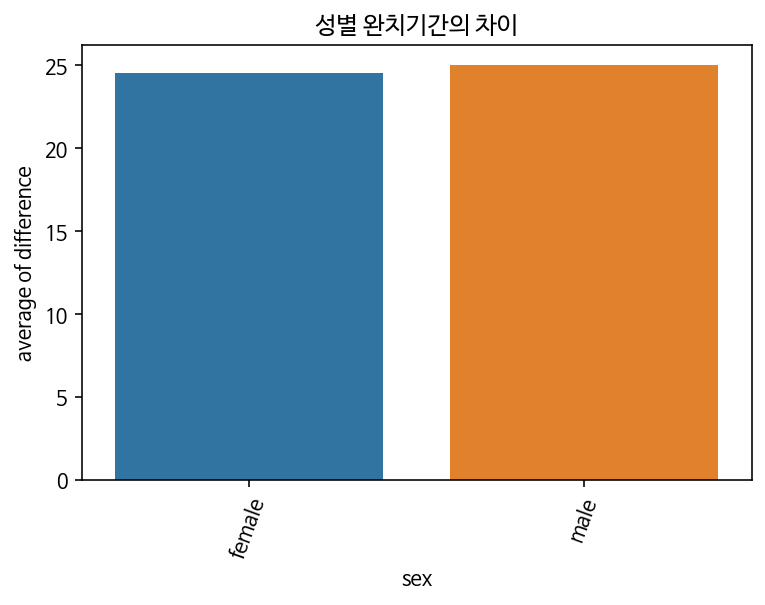

In [100]:
sns.barplot(x='sex',y='avg',data=patientInfo_sex_diff)
plt.title('성별 완치기간의 차이')
plt.xlabel('sex')
plt.ylabel('average of difference')
plt.xticks(rotation=70)
plt.show()

* 차이가 너무 적어서, 거의 같은 걸로 보인다.....



---
patientInfo 데이터만을 활용해서 3가지 기준별 완치기간의 차이가 있는지 확인해보았다. 나이대를 제외하고는 별다른 경향성을 나타내지 않는다는 것을 확인할 수 있었다~ (그닥 유의미한 결과는 아닌듯 ..^^)


